In [137]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [138]:
# Parameters
n = 30
C = 10
meanT = 9.3
meanM = 30
oneItemST = 3


# Factors

# FME_Exponential
p = [0.1,0.2,0.3]
K = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]


# CSV name
csv_name = "FME_Exponential_b_New"

In [139]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "vector"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_18552\2527533774.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [140]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: exponential(30s,_0)
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]

CSV_Vector = CSV[CSV["type"] == "vector"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:vector"]

# W: Mean Waiting Time [Queues]
Exp_W = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = Exp_W[Exp_W["name"] == "queueingTime:vector"]

# Dictionary for containing all the DataFrames
CSV_Dict = {
    "TW": Exp_TW,
    "W": Exp_W
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[2]] = row["attrvalue"].replace("/", "_")


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[2]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if key == "W":
                PI[key][config[run]][run][string] = row["vecvalue"]

            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if key == "TW":
                PI[key][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][config[run]][run] = float(row["value"])


# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [141]:
# from statsmodels.graphics.gofplots import qqplot
# from pandas.plotting import lag_plot
# import scipy.stats as stats

# values = PI_df["W"]["0.1_14"]["Q0"].iloc[0]
# values = values.split(" ")
# values = [float(i) for i in values]
# values = pd.DataFrame(values)
# lag_plot(values)
# plt.show()
# subsample = values.sample(frac=0.2)
# subsample.sort_index(inplace=True)
# lag_plot(subsample)
# plt.show()
# #Crea il grafico
# sns.distplot(values, hist=False, fit=stats.lognorm, 
#              kde=False,  # Disabilita il KDE
#              fit_kws={"label": "LogNormal"})

# #Aggiungi le etichette e la legenda
# plt.xlim(-10,100)
# plt.xlabel("Valori")
# plt.ylabel("Densità")
# plt.legend()

# #Mostra il grafico
# plt.show()
# #Imposta il contesto di Seaborn (opzionale)
# sns.set()

# sns.distplot(values, hist=False, rug=True)
# plt.show()


In [142]:
# Subsampling and Mean Computation

for key in PI_df:
    for p_ in p:
        for K_ in K:
            for index, row in PI_df[key][f"{p_}_{K_}"].iterrows():
                if key != "TW":
                    for q in Q:
                        values = row[q].split(" ")
                        values = [float(v) for v in values]
                        values = pd.DataFrame(values)
                        subsample = values.sample(frac=0.2)
                        PI_df[key][f"{p_}_{K_}"].loc[index, q] = subsample.mean()[0]
                else:
                    values = row["GS"].split(" ")
                    values = [float(v) for v in values]
                    values = pd.DataFrame(values)
                    subsample = values.sample(frac=0.3)
                    PI_df["TW"][f"{p_}_{K_}"].loc[index, "GS"] = subsample.mean()[0]

In [143]:
PI_df["W"]["0.1_14"]

,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9
0,76.29916,295.651361,276.197208,255.586916,191.0279,277.398893,211.734989,215.812138,202.475161,160.305933
1,85.813269,443.34233,526.279028,392.92282,446.169542,357.424409,303.215582,356.247607,373.251373,318.044951
2,61.855425,223.112144,203.33467,227.025008,219.687384,178.506017,174.813739,169.520039,186.78295,153.25502
3,93.436463,502.840297,497.924824,456.662085,432.181937,503.273555,365.887711,425.198948,369.984972,471.493643
4,90.284285,603.488087,541.210956,566.415039,550.518797,568.052246,533.846868,549.808111,592.661624,532.903274
5,158.009465,358.949852,308.700121,338.084691,367.254349,322.706083,292.823644,308.32051,254.835954,295.692326
6,105.79092,399.135651,420.510189,379.561226,415.038102,347.639128,433.45851,368.883302,343.7496,297.316428
7,87.367935,290.000961,307.31369,244.670978,225.592788,235.08478,233.763778,203.843241,186.472333,197.018217
8,112.756579,560.791847,586.514259,614.629473,602.797649,560.157125,609.241845,482.37805,422.151366,468.393197
9,88.201879,388.903448,422.119974,406.305176,421.564206,321.002008,329.832207,281.277048,300.077189,303.626994


In [144]:
pi = "TW"
P_LOG = {}
P_LOG[pi] = {}

for p_ in p:
    for K_ in K:
        P_LOG[pi][f"{p_}_{K_}"] = pd.DataFrame(columns=["GS"])
        P_LOG[pi][f"{p_}_{K_}"]["GS"] = np.log(PI_df[pi][f"{p_}_{K_}"]["GS"].values.astype(np.float64).tolist())


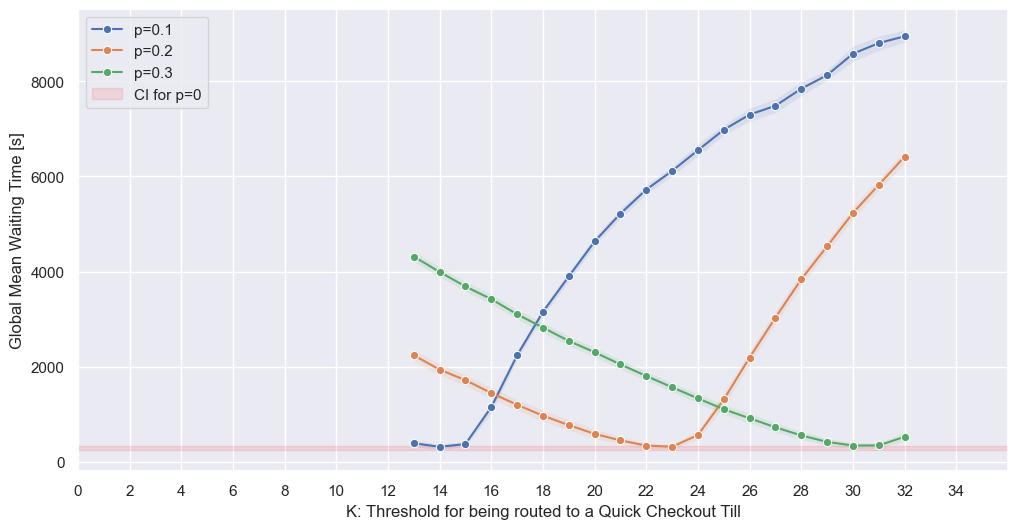

In [145]:
# (Normal)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"


for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
# plt.fill_between(y=[243.477, 330.132], alpha=0.1)
# plt.axhline(y=243.477, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=330.132, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([243.477, 330.132], 0, 36, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 36, 2))

# Set the x-axis limits
plt.xlim(0, 36)  
# Set the y-axis limits
# plt.ylim(250, 450)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

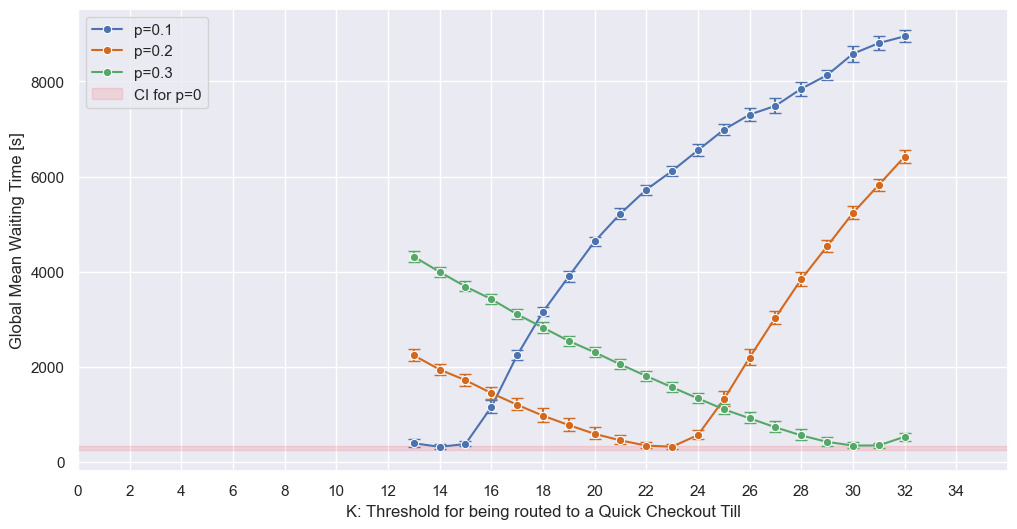

In [146]:
# (Cox Method)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

temp_colors = ["b", "chocolate", "g"]
colors = {}
for p_ in p:
    colors[p_] = temp_colors.pop(0)

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_AA = []
    ci_BB = []

    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][couple]["GS"].mean() - np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))) - PI_df[pi][couple]["GS"].mean())

        ci_lb.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    # plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=K, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=4, color=colors[p_])

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}", color=colors[p_])


# Mean Value in the case of p = 0 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
# plt.fill_between(y=[243.477, 330.132], alpha=0.1)
# plt.axhline(y=243.477, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=330.132, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([243.477, 330.132], 0, 36, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 36, 2))

# Set the x-axis limits
plt.xlim(0, 36)  
# Set the y-axis limits
# plt.ylim(250, 450)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

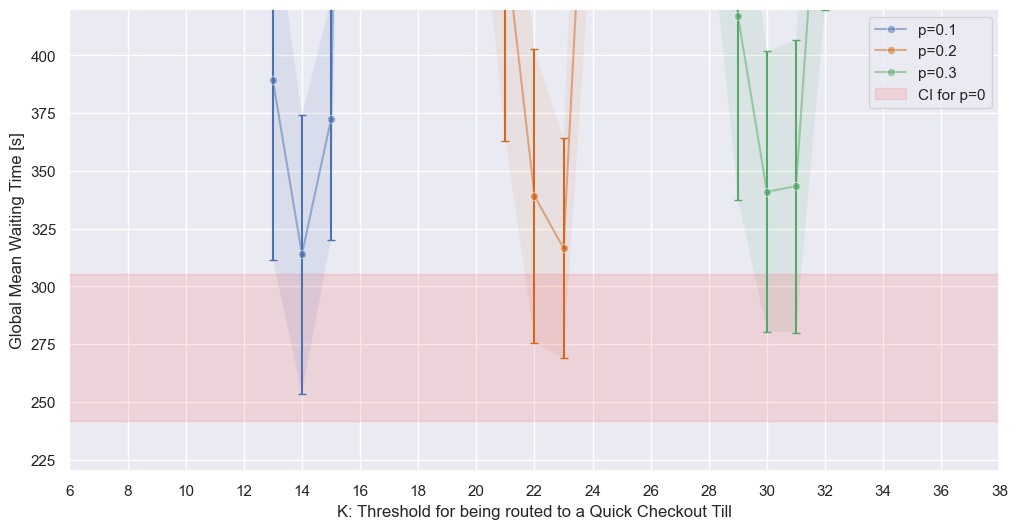

In [147]:
# (Normal)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

temp_colors = ["b", "chocolate", "g"]
colors = {}
for p_ in p:
    colors[p_] = temp_colors.pop(0)

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci = []
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        ci.append(1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n)))
        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))


    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    plt.errorbar(x=K, y=y_W, fmt='o', yerr=ci, markersize=2, capsize=3, color=colors[p_])

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}", color=colors[p_], lw=1.5, alpha=0.5)


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(6, 38)  
# Set the y-axis limits
plt.ylim(220, 420)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system [Zoomed]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

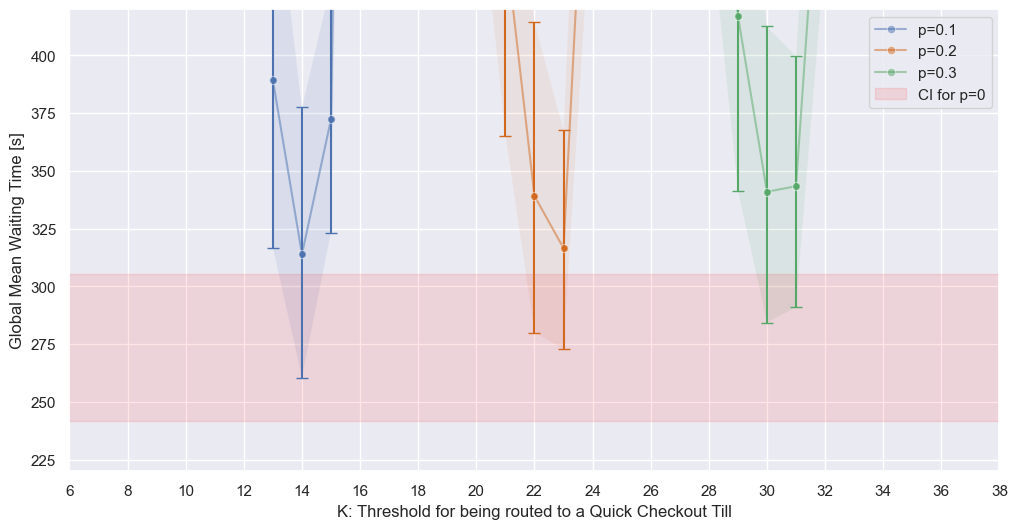

In [148]:
# (Cox Method)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

temp_colors = ["b", "chocolate", "g"]
colors = {}
for p_ in p:
    colors[p_] = temp_colors.pop(0)

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_AA = []
    ci_BB = []
    
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][couple]["GS"].mean() - np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))) - PI_df[pi][couple]["GS"].mean())

        ci_lb.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=K, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=4, color=colors[p_])

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}", color=colors[p_], lw=1.5, alpha=0.5)


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(6, 38)  
# Set the y-axis limits
plt.ylim(220, 420)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system [Zoomed]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

In [149]:
pi = "W"
# P_LOG = {}
P_LOG[pi] = {}

for p_ in p:
    for K_ in K:
        P_LOG[pi][f"{p_}_{K_}"] = pd.DataFrame(columns=Q)
        for q in Q:
            P_LOG[pi][f"{p_}_{K_}"][q] = np.log(PI_df[pi][f"{p_}_{K_}"][q].values.astype(np.float64).tolist())


C:\Users\giova\AppData\Local\Temp\ipykernel_18552\3726910953.py:9: RuntimeWarning: divide by zero encountered in log
  P_LOG[pi][f"{p_}_{K_}"][q] = np.log(PI_df[pi][f"{p_}_{K_}"][q].values.astype(np.float64).tolist())
C:\Users\giova\AppData\Local\Temp\ipykernel_18552\3726910953.py:9: RuntimeWarning: divide by zero encountered in log
  P_LOG[pi][f"{p_}_{K_}"][q] = np.log(PI_df[pi][f"{p_}_{K_}"][q].values.astype(np.float64).tolist())


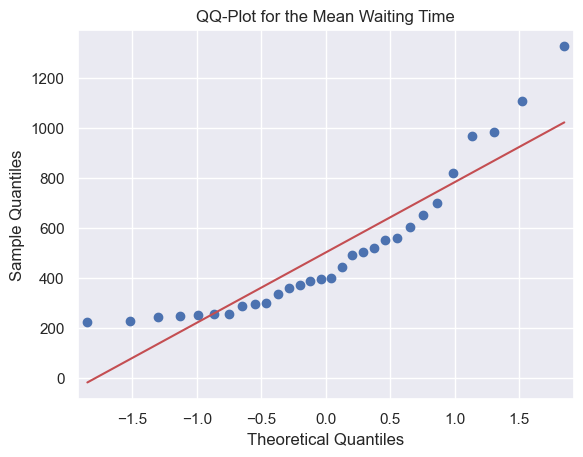

In [150]:
from statsmodels.graphics.gofplots import qqplot

qqplot(PI_df["W"]["0.1_14"]["Q1"], line='s')
plt.title('QQ-Plot for the Mean Waiting Time')
plt.show()

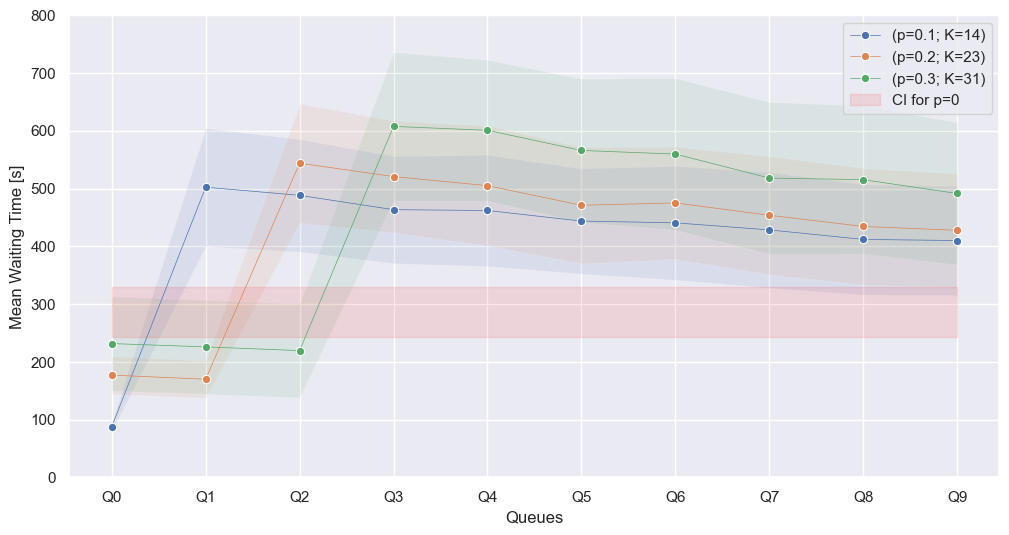

In [151]:
# (Normal)
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        ci_lb.append(PI_df[pi][cc][q].mean() - (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][cc][q].mean() + (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5)


# Mean Value in the case of p = 0 (and K=0) 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
plt.fill_betweenx([243.477, 330.132], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 800)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

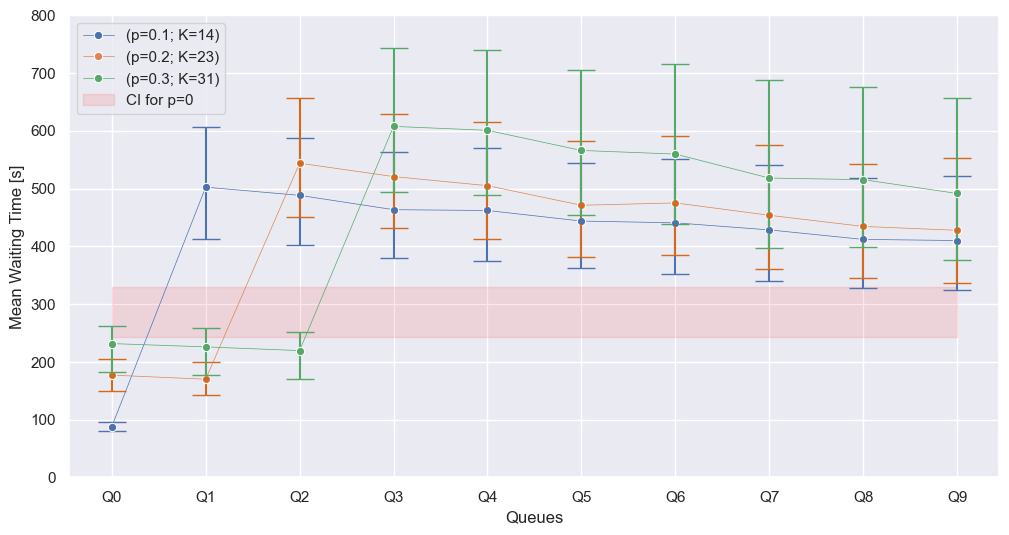

In [152]:
# (Cox Method)
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

temp_colors = ["b", "chocolate", "g"]
colors = {}
for cc in configurations:
    colors[cc] = temp_colors.pop(0)

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []


    ci_AA = []
    ci_BB = []
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][cc][q].mean() - np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))) - PI_df[pi][cc][q].mean())

        ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    #plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=Q, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=10, color=colors[cc])

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5)


# Mean Value in the case of p = 0 (and K=0) 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
plt.fill_betweenx([243.477, 330.132], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 800)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

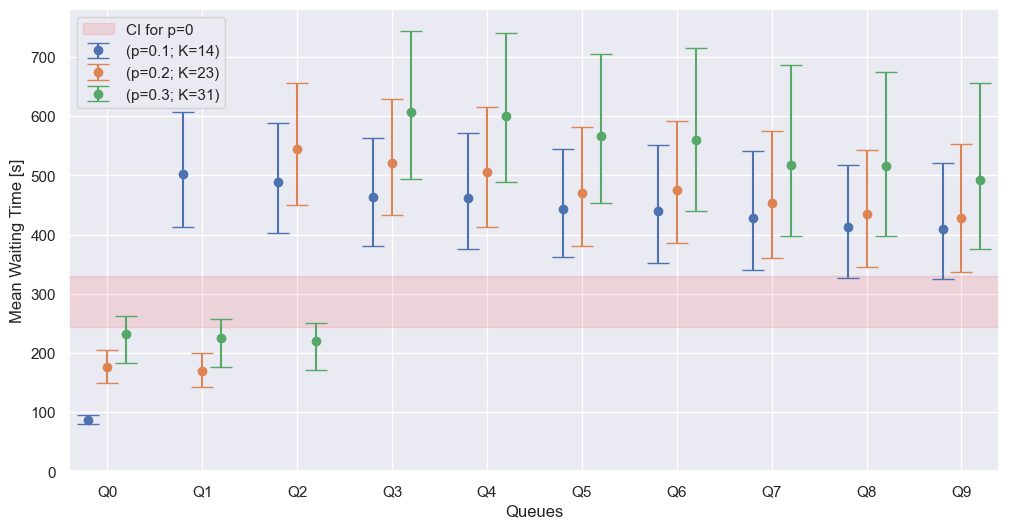

In [153]:
# (Cox Method)
# (BarPlot)
configurations = ["0.1_14", "0.2_23", "0.3_31"]

# width of the bars
barWidth = 0.2

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

rx = np.arange(len(Q))

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_AA = []
    ci_BB = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][cc][q].mean() - np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))) - PI_df[pi][cc][q].mean())

    # Plot invisible bars
    plt.bar(rx, [0] * len(Q), width=barWidth, edgecolor='black', lw=0, alpha=0)

    # Plot mean and confidence intervals using errorbar
    plt.errorbar(
        [r + barWidth for r in rx],
        y_W,
        yerr=[ci_AA, ci_BB],
        fmt='o',
        capsize=8,
        label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})",
    )

    rx = [x + barWidth for x in rx]


# Mean Value in the case of p = 0 (and K=0) 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
plt.fill_betweenx([243.477, 330.132], 0, 10.5, color='red', alpha=0.1, label="CI for p=0")


# Set the x-axis limits
plt.xlim(0, 9.8)  
# Set the y-axis limits
# plt.ylim(0, 900)  

plt.xticks([r + barWidth*2 for r in range(len(Q))], Q)
# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

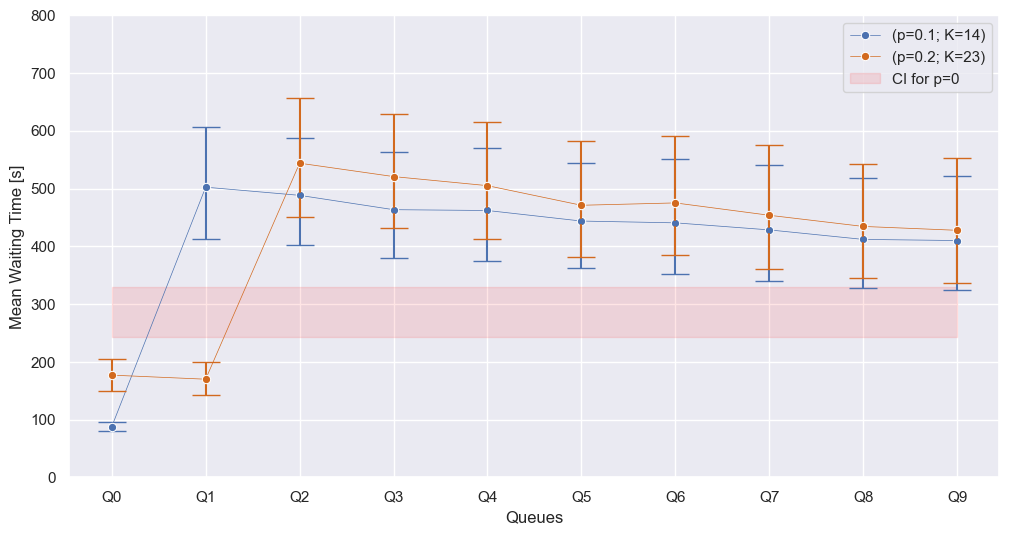

In [154]:
# (Cox Method)
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

temp_colors = ["b", "chocolate"]
colors = {}
for cc in configurations:
    colors[cc] = temp_colors.pop(0)

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []


    ci_AA = []
    ci_BB = []
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][cc][q].mean() - np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))) - PI_df[pi][cc][q].mean())

        ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    #plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=Q, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=10, color=colors[cc])

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5, color=colors[cc])


# Mean Value in the case of p = 0 (and K=0) 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
plt.fill_betweenx([243.477, 330.132], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 800)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

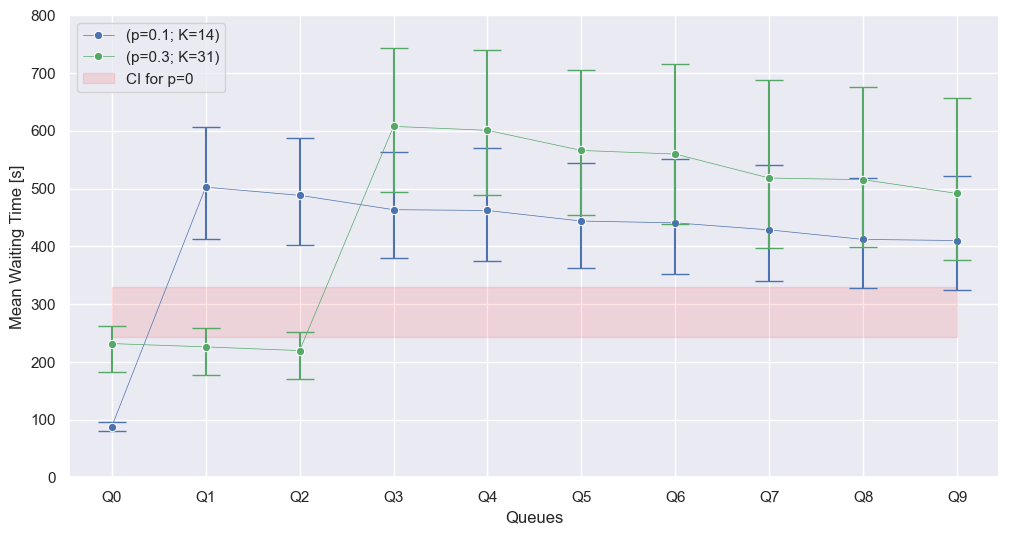

In [155]:
# (Cox Method)
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

temp_colors = ["b", "g"]
colors = {}
for cc in configurations:
    colors[cc] = temp_colors.pop(0)

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []


    ci_AA = []
    ci_BB = []
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][cc][q].mean() - np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))) - PI_df[pi][cc][q].mean())

        ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    #plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=Q, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=10, color=colors[cc])

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5, color=colors[cc])


# Mean Value in the case of p = 0 (and K=0) 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
plt.fill_betweenx([243.477, 330.132], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 800)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

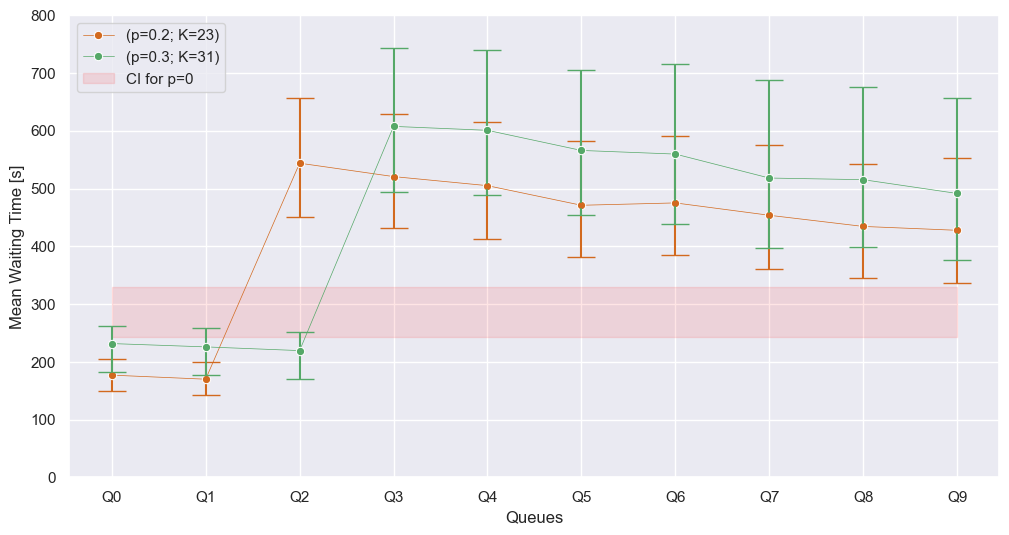

In [156]:
# (Cox Method)
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

temp_colors = ["chocolate", "g"]
colors = {}
for cc in configurations:
    colors[cc] = temp_colors.pop(0)

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []


    ci_AA = []
    ci_BB = []
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][cc][q].mean() - np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))) - PI_df[pi][cc][q].mean())

        ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    #plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=Q, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=10, color=colors[cc])

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5, color=colors[cc])


# Mean Value in the case of p = 0 (and K=0) 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
plt.fill_betweenx([243.477, 330.132], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 800)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

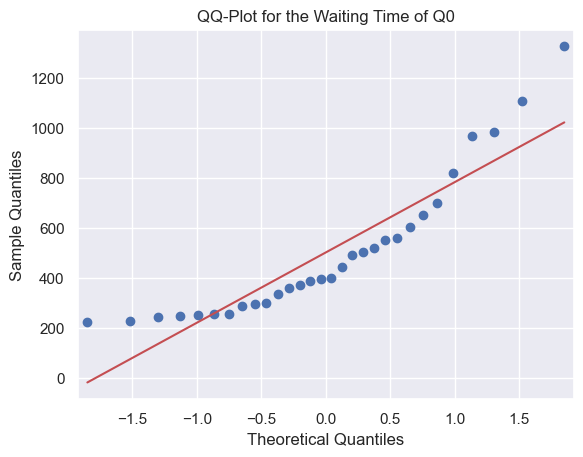

In [157]:
from statsmodels.graphics.gofplots import qqplot
import numpy as np
# Plot QQ-Plot for the Waiting Time of Q0
import matplotlib.pyplot as plt

qqplot(PI_df["W"]["0.1_14"]["Q1"], line='s')
plt.title('QQ-Plot for the Waiting Time of Q0')
plt.show()

In [158]:
PI_df["W"]["0.1_14"]["Q1"].std()**2

81753.41610980008

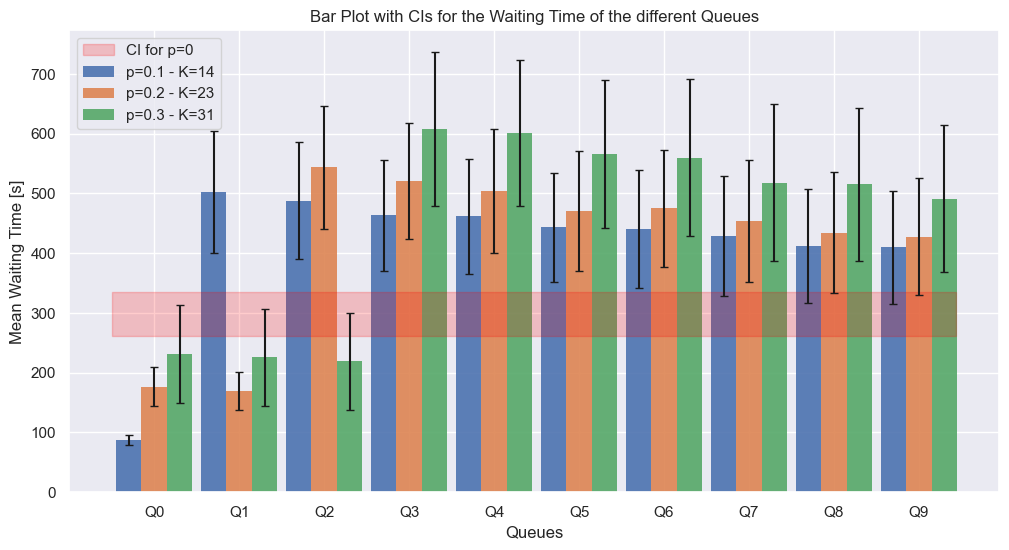

In [159]:
# (BarPlot) Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

# width of the bars
barWidth = 0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))


# Performance Index
pi = "W"

rx = np.arange(len(Q))

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    y_err = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        y_err.append(1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n)))

    plt.bar(rx, y_W, width = barWidth, edgecolor = 'black', yerr=y_err, capsize=3, label=f"p={cc.split('_')[0]} - K={cc.split('_')[1]}", lw=0, alpha=0.9)
    rx = [x + barWidth for x in rx]


# Mean Value in the case of p = 0 (and K=0) 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
plt.fill_betweenx([262.118, 335.403], -0.2, 9.74, color='red', alpha=0.2, label="CI for p=0")


# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
# plt.ylim(0, 900)  

plt.xticks([r + barWidth for r in range(len(Q))], Q)
plt.title('Bar Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

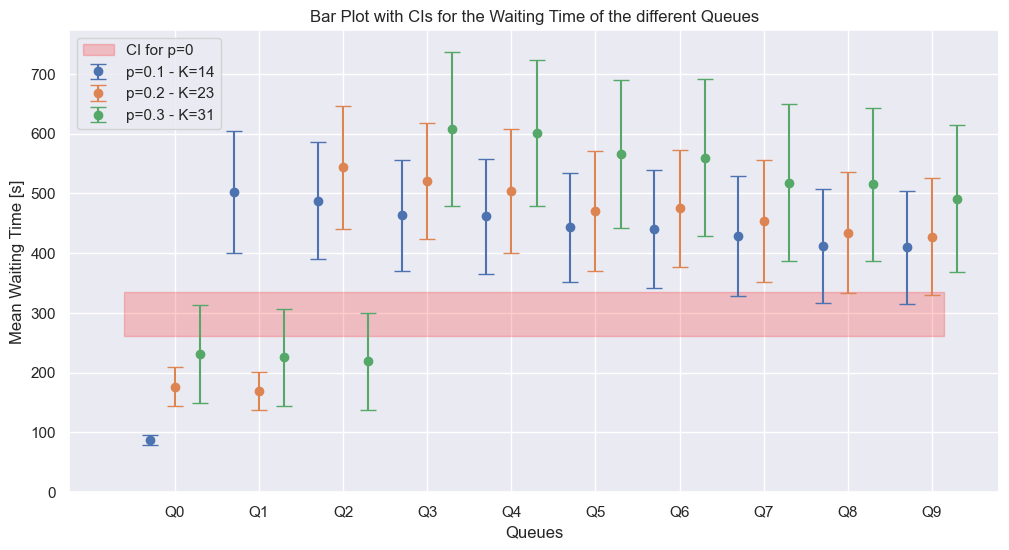

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Sample data
configurations = ["0.1_14", "0.2_23", "0.3_31"]

# Width of the bars
barWidth = 0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

rx = np.arange(len(Q))

for cc in configurations:
    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    y_err = []

    for q in Q:
        y_W.append(PI_df[pi][cc][q].mean())
        y_err.append(1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n)))

    # Plot invisible bars
    plt.bar(rx, [0] * len(Q), width=barWidth, edgecolor='black', lw=0, alpha=0)

    # Plot mean and confidence intervals using errorbar
    plt.errorbar(
        [r + barWidth for r in rx],
        y_W,
        yerr=y_err,
        fmt='o',
        capsize=6,
        label=f"p={cc.split('_')[0]} - K={cc.split('_')[1]}",
    )

    rx = [x + barWidth for x in rx]

# Fill between confidence intervals for p=0
plt.fill_betweenx([262.118, 335.403], 0, 9.74, color='red', alpha=0.2, label="CI for p=0")

plt.xticks([r + barWidth*2 for r in range(len(Q))], Q)
plt.title('Bar Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')
plt.legend()
plt.show()
